# Fixing Colin's new image formatting to match my brittle code 

I need to change the channel order of the new images to match the order of the pre-exisiting images. After that, I will save them to files with names that match my conventions. 

Run using the Mesmer_pypi conda environment

In [1]:
import numpy as np
import tifffile 
import os 
import re
import pandas as pd
from matplotlib import pyplot as plt
import glob

## Functions

In [3]:
def make_markers_file(dir_name : str, resolution : str, sample_id : "str") -> pd.DataFrame:
    ## Take in new dir name
    markers = re.sub(resolution + "_pan_", "", dir_name)
    markers = re.sub("_" + sample_id + "$", "", markers)    
    markers = markers.split("_")

    markers_df = pd.DataFrame(markers)
    markers_df.columns = ["marker_name"]
    markers_df["row_num"] = range(0, len(markers_df)) 
    markers_df["cycle"] = 0
    markers_df= markers_df[["cycle", "marker_name", "row_num"]]
    
    return markers_df

def convert_ome(img_dir, image_regex= "image.tif") -> None:
    img_path = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if re.search(image_regex, img_file) and not img_file.startswith(".")]
    assert len(img_path)  == 1, f"More than one image file in {img_dir}"
    img_path= img_path[0]
    img= tifffile.imread(img_path)
    ome_path = re.sub(r".tif$|.ome.tif$", ".ome.tif", img_path)
    tifffile.imwrite(ome_path, img)
    return None

def remove_tif(img_dir, image_to_remove= "image.tif") -> None:
    img_path = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if re.search(image_to_remove, img_file) and not img_file.startswith(".")]
    assert len(img_path)  == 1, f"More than one image file in {img_dir}"
    img_path = img_path[0]
    os.remove(img_path)
    return None

def reorder_markers(img_dir, image_regex= ".tif$", show_plots= True):
    img_file = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if re.search(image_regex, img_file) and not img_file.startswith(".")]
    print(img_file)
    assert len(img_file)  == 1, f"More than one image file in {img_dir}"
    img_file = img_file[0] ## Converting from list 
    img = tifffile.imread(img_file)

    if show_plots:
        ## Show original order
        _, ax = plt.subplots(1,4)
        ax[0].imshow(img[0], interpolation= "nearest")
        ax[1].imshow(img[1], interpolation= "nearest")
        ax[2].imshow(img[2], interpolation= "nearest")
        ax[3].imshow(img[3], interpolation= "nearest")
        plt.show()

    ## Re-ordering images 
    if re.search(r"aDC1|DAPI_CD63_CD11c_XCR1", img_file):
        ## Colin order: DAPI, CD11c, CD63, XCR1
        ## Needed order: DAPI, CD63, CD11c, XCR1
        reordered_img = img[[0,2,1,3], ...].copy()
    elif re.search(r"aDC2|DAPI_CD63_CD11c_Sirpa", img_file):
        ## Colin order: DAPI, Sirpa, CD63, CD11c
        ## Needed order: DAPI, CD63, CD11c, Sirpa
        reordered_img= img[[0,2,3,1], ...].copy()
    elif re.search(r"pDC|DAPI_B220_CD11c_SiglecH", img_file):
        ## Colin order: DAPI, B220, SiglecH, CD11c
        ## Needed order: DAPI, B220, CD11c, SiglecH
        reordered_img = img[[0,1,3,2], ...].copy()
    elif re.search(r"CD14_cDC2|DAPI_Sirpa_CD11c_CD14", img_file):
        ## Colin order: DAPI, CD11c, Sirpa, CD14
        ## Needed order: DAPI, Sirpa, CD11c, CD14
        reordered_img= img[[0,2,1,3],...].copy()
    elif re.search(r"CD207_cDC1|DAPI_CD207_CD11c_XCR1|Sirpa_CD63_Mertk|DAPI_Sirpa_CD63_MerTK", img_file):
        reordered_img = img
        ## Other markers don't need changes. Segmentation marker is already the third marker. 
    
    ## Plotting images in the loop to make sure the transpose is correct. 
    if show_plots:
        ## Show new order
        _, ax = plt.subplots(1,4)
        ax[0].imshow(reordered_img[0], interpolation= "nearest")
        ax[1].imshow(reordered_img[1], interpolation= "nearest")
        ax[2].imshow(reordered_img[2], interpolation= "nearest")
        ax[3].imshow(reordered_img[3], interpolation= "nearest")
        plt.show()

    ## Did the ordering actually change?
    assert not np.all((reordered_img, img)), "The dimensions are still the same."
    
    tifffile.imwrite(os.path.join(img_dir, "reordered_image.ome.tif"), reordered_img)
    return None 

def rename_dir(img_dir, resolution= "20x") -> None:
    sample_id = img_dir[-1] 
        ## The last letter is the sample ID 
    base_path= re.search("(/.*./)", img_dir).group(1)
        ## Capture all directories, except for the last one. 

    if re.search("aDC1", img_dir):
        new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_XCR1_" + sample_id
    elif re.search("aDC2", img_dir):
        new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_Sirpa_" + sample_id
    elif re.search("CD14_cDC2", img_dir):
        new_dir_name = resolution + "_pan_DAPI_Sirpa_CD11c_CD14_" + sample_id
    elif re.search("CD207_cDC1", img_dir):   
        new_dir_name= resolution + "_pan_DAPI_CD207_CD11c_XCR1_" + sample_id
    elif re.search("pDC", img_dir):
        new_dir_name = resolution + "_pan_DAPI_B220_CD11c_SiglecH_" + sample_id
    elif re.search("Sirpa_CD63_Mertk", img_dir): 
        new_dir_name = resolution + "_pan_DAPI_Sirpa_CD63_MerTK_" + sample_id
        
    new_dir = os.path.join(base_path, new_dir_name)

    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    os.rename(img_dir, new_dir)
    return None 


def add_marker_csv(new_dir) -> None:
    sample_id = new_dir[-1]
    new_dir_name = re.sub(r"^.*/", "", new_dir)
    resolution = re.search(r'\b(\d+x)', new_dir_name).group(1)
        ## \b represents a word boundary (in this case the start of the sentence"
        ## \d+ matches any number of digits until an "x" appears
        ## \b ends the match at the underscore explicitly. 
        ## group 1 gets the captured resolution in the parantheses. 
    
    markers_df = make_markers_file(dir_name     = new_dir_name, 
                                   resolution   = resolution,
                                   sample_id    = sample_id)
    markers_df.to_csv(os.path.join(new_dir, "markers.csv"), index= False, header= True)
    return None 

['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_C/edited_DAPI_Sirpa-488_CD11c-594_CD14-647.tif']


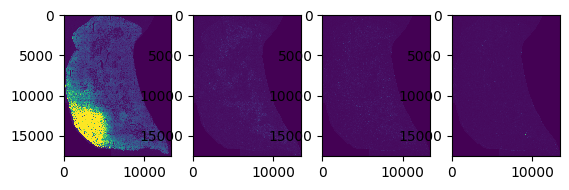

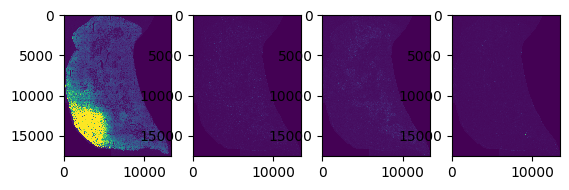

['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_A/DAPI_Sirpa-488_CD11c-594_CD14-647.tif']


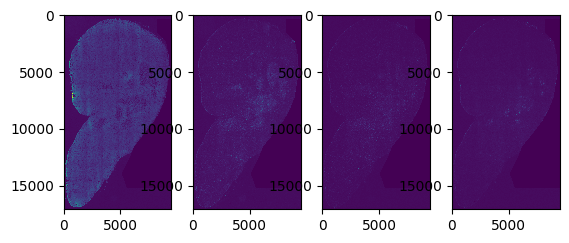

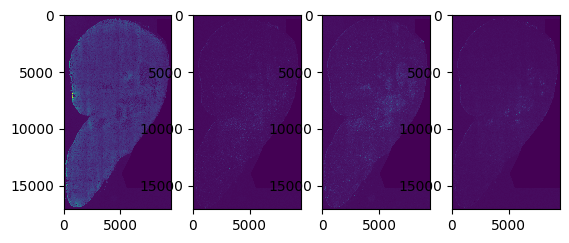

['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_B/edited_DAPI_Sirpa-488_CD11c-594_CD14-647.tif']


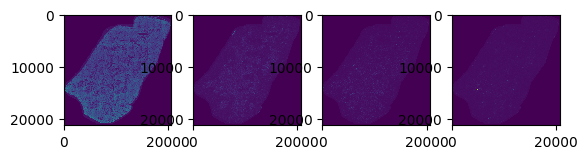

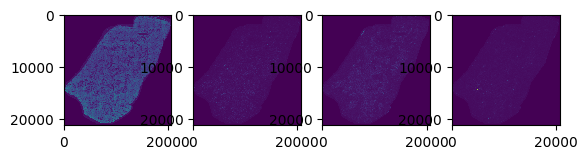

In [9]:
raw_dir= "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
CD14_dirs= [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_CD14_[A-D]$", img_dir)]

for img_dir in CD14_dirs:
    reorder_markers(img_dir, image_regex= "^(edited_DAPI|DAPI)", show_plots= True)
    ## Re-running these b/c Colin had the wrong order originally. 

## Re-running images from beginning 

In [4]:
raw_dir= "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
img_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_[A-D]$", img_dir)]
img_dirs.sort()

for img_dir in img_dirs:
    print(img_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD14_cDC2_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD14_cDC2_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD14_cDC2_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD207_cDC1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD207_cDC1_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD207_cDC1_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/CD207_cDC1_D
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/Sirpa_CD63_Mertk_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/Sirpa_CD63_Mertk_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/Sirpa_CD63_Mertk_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/Sirpa_CD

In [25]:
for img_dir in img_dirs:
    reorder_markers(img_dir, image_regex= ".tif$", show_plots= False)
## Printing the plots increases run time by about 4x

['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A/edited_DAPI_B220-488_SiglecH-594_CD11c-647.tif']


Done with /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A
['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B/DAPI_B220-488_SiglecH-594_CD11c-647.tif']
Done with /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_C/DAPI_B220-488_SiglecH-594_CD11c-647.tif']
Done with /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_C
['/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_A/072723_DAPI_CD207-488_CD11c-594_XCR1-647.tif']
Done with /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_A
['/stor/scratch/Ehrlich/Users/John/histocytometry/

In [16]:
for img_dir in img_dirs:
    rename_dir(img_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images

In [20]:
new_img_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_[A-D]$", img_dir)]
new_img_dirs.sort()

for img_dir in new_img_dirs:
    print(img_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_D
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_Sirpa_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_Sirpa_B
/stor/scratch

In [21]:
for img_dir in new_img_dirs:
    add_marker_csv(new_dir= img_dir)

# Obsolete Code

## Reformatting images 

In [5]:
## Getting files 
raw_dir= "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images"
img_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_(A|B|C)$", img_dir)]
img_dirs.sort()

## Was anything wrong with Sirpa_CD63_MerTK_B? 
## Why am I not looking at it? 

## All other images have been run. 

In [6]:
for img_dir in img_dirs:
    print(img_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_B220_CD11c_SiglecH_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_B220_CD11c_SiglecH_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_B220_CD11c_SiglecH_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_Sirpa_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_Sirpa_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_Sirpa_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_XC

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_B220_CD11c_SiglecH_A


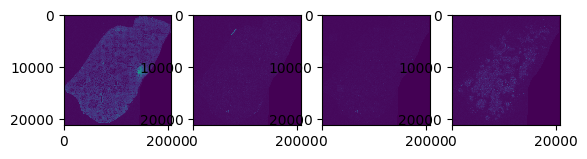

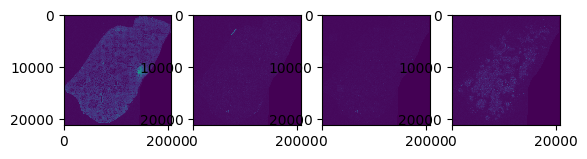

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_B220_CD11c_SiglecH_B


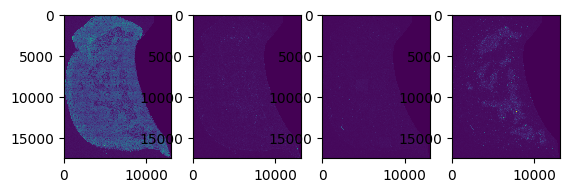

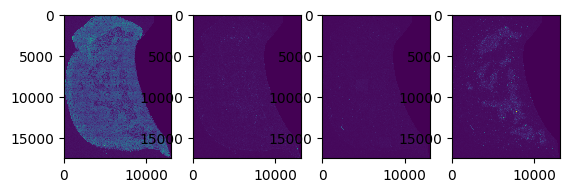

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_B220_CD11c_SiglecH_C


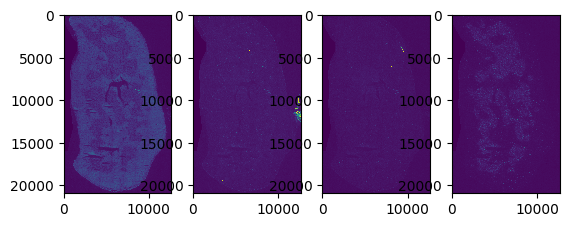

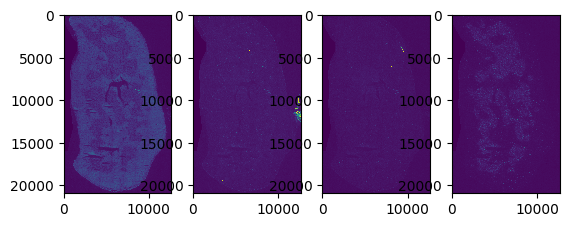

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_A


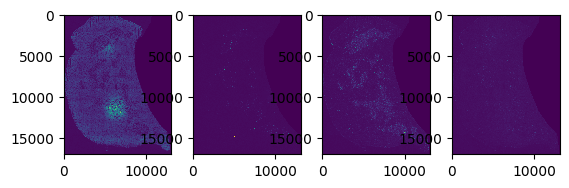

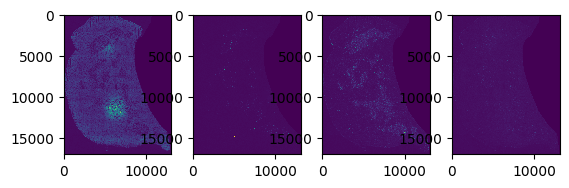

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_B


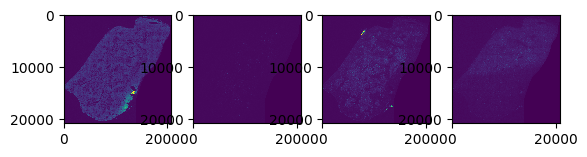

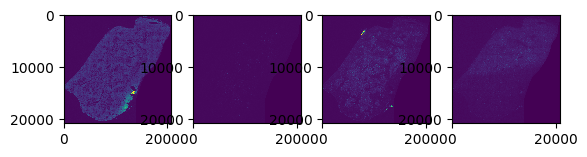

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_C


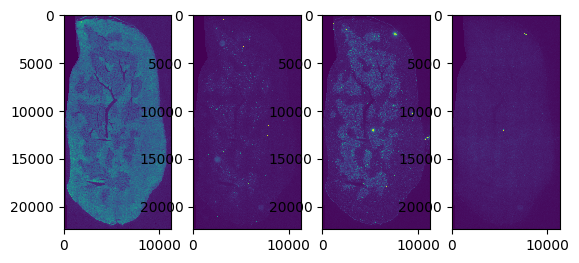

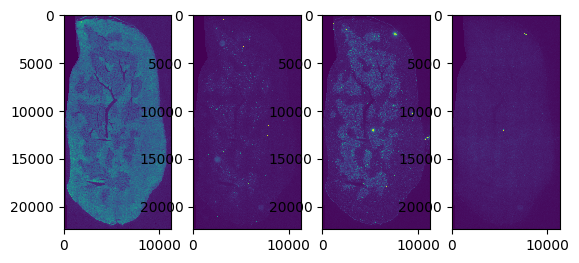

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_Sirpa_A


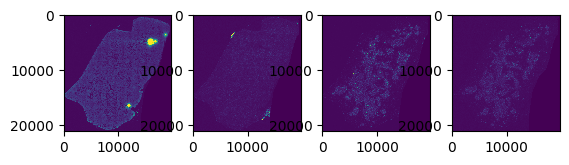

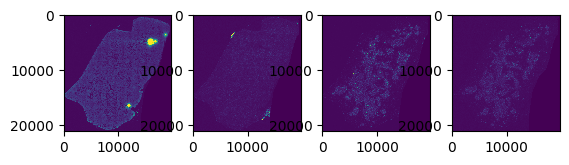

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_Sirpa_B


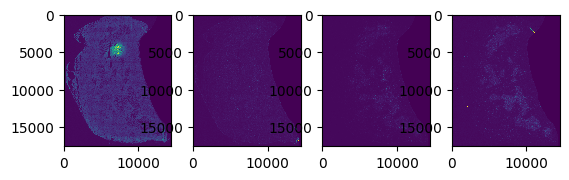

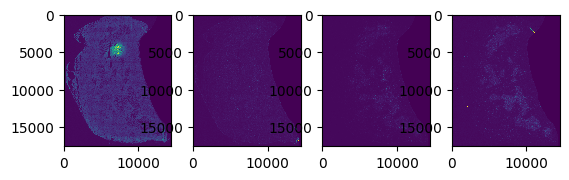

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_Sirpa_C


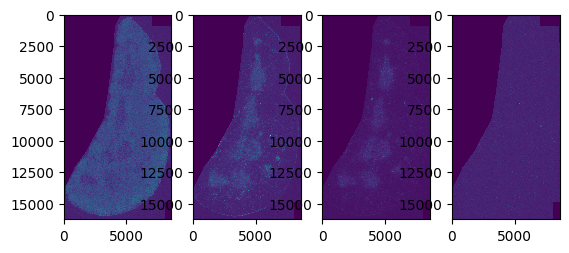

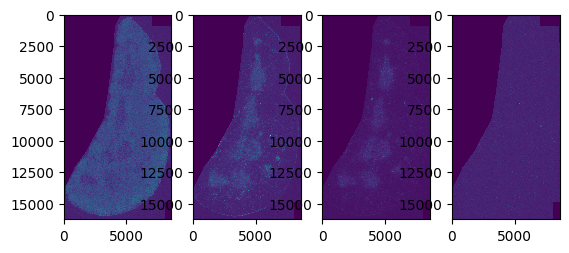

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_XCR1_A


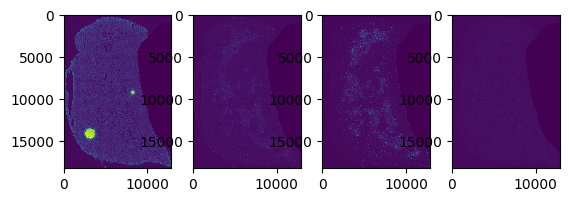

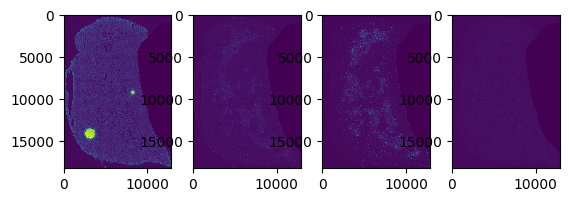

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_XCR1_B


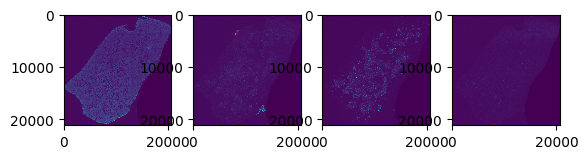

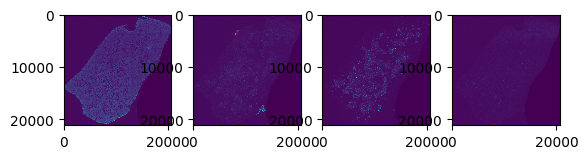

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD63_CD11c_XCR1_C


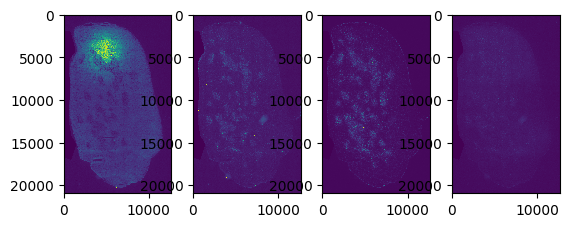

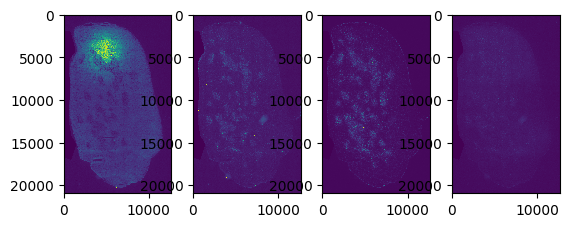

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD11c_CD14_A


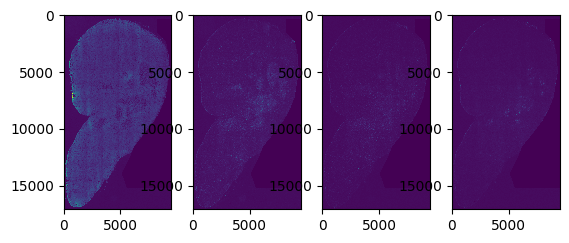

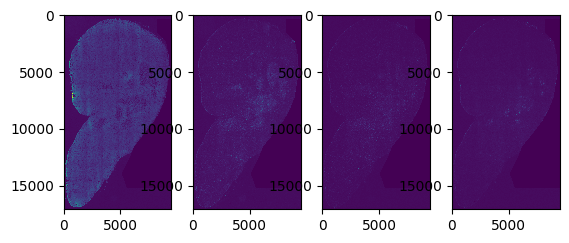

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD11c_CD14_B


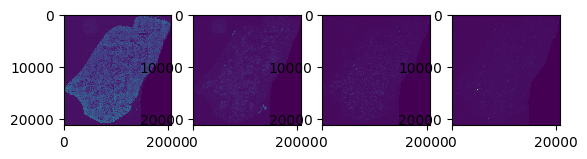

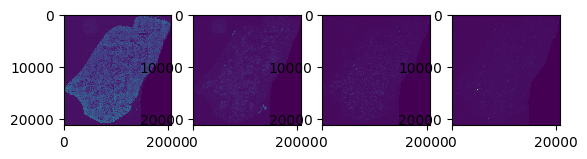

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD11c_CD14_C


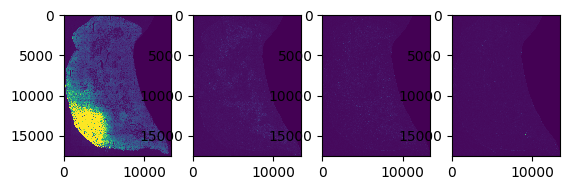

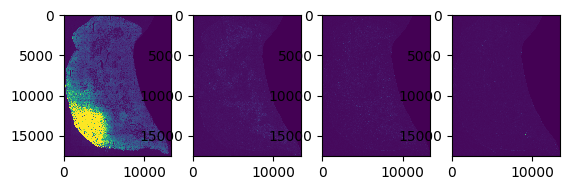

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD63_MerTK_A


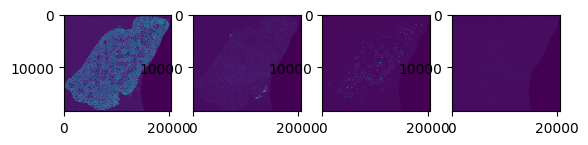

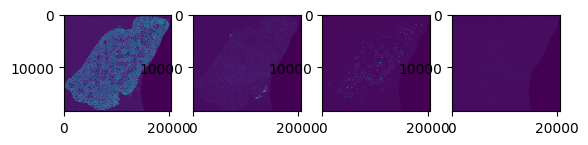

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD63_MerTK_C


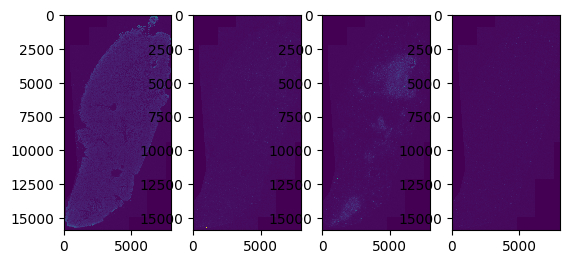

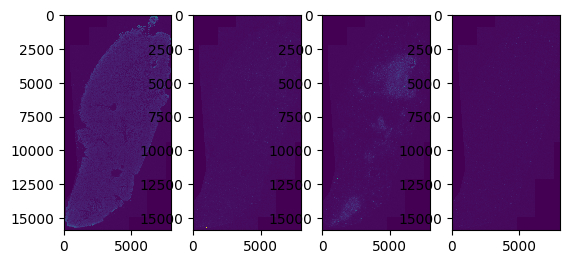

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/Sirpa_CD63_Mertk_B


FileNotFoundError: [Errno 2] No such file or directory: '/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/Sirpa_CD63_Mertk_B/image.tif'

In [8]:
resolution= "20x"

for img_dir in img_dirs:
    print(img_dir)
    # img_file = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if re.search(".tif$", img_file)][0]
    # img_file = os.path.join(img_dir, "image.tif")
    colin_img = tifffile.imread(img_file)
    sample_id = img_dir[-1] 
        ## The last letter is the sample ID     

    _, ax = plt.subplots(1,4)
    ax[0].imshow(colin_img[0], interpolation= "nearest")
    ax[1].imshow(colin_img[1], interpolation= "nearest")
    ax[2].imshow(colin_img[2], interpolation= "nearest")
    ax[3].imshow(colin_img[3], interpolation= "nearest")
    plt.show()

    if re.search("aDC1", img_file):
        new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_XCR1_" + sample_id
        ## Colin order: DAPI, CD11c, CD63, XCR1
        ## Needed order: DAPI, CD63, CD11c, XCR1
        colin_img = colin_img[[0,2,1,3], ...]
    elif re.search("aDC2", img_file):
        new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_Sirpa_" + sample_id
        ## Colin order: DAPI, Sirpa, CD63, CD11c
        ## Needed order: DAPI, CD63, CD11c, Sirpa
        colin_img= colin_img[[0,2,3,1], ...]
    elif re.search("CD14_cDC2", img_file):
        new_dir_name = resolution + "_pan_DAPI_Sirpa_CD11c_CD14_" + sample_id
        ## Same ordering here, only need to change directory name 
    elif re.search("CD207_cDC1", img_file):   
        new_dir_name= resolution + "_pan_DAPI_CD207_CD11c_XCR1_" + sample_id
        ## I don't have any CD207, so this ordering is fine. Although, the name is too verbose. 
    elif re.search("pDC", img_file):
        new_dir_name = resolution + "_pan_DAPI_B220_CD11c_SiglecH_" + sample_id
        ## Colin order: DAPI, B220, SiglecH, CD11c
        ## Needed order: DAPI, B220, CD11c, SiglecH
        colin_img = colin_img[[0,1,3,2], ...]
    elif re.search("Sirpa_CD63_Mertk", img_file): 
        new_dir_name = resolution + "_pan_DAPI_Sirpa_CD63_MerTK_" + sample_id
        ## I don't have any Sirpa_CD63_MerTK, so this ordering is fine. Although, the name is too verbose. 

    ## Plotting images in the loop to make sure the transpose is correct. 
    _, ax = plt.subplots(1,4)
    ax[0].imshow(colin_img[0], interpolation= "nearest")
    ax[1].imshow(colin_img[1], interpolation= "nearest")
    ax[2].imshow(colin_img[2], interpolation= "nearest")
    ax[3].imshow(colin_img[3], interpolation= "nearest")
    plt.show()

    ## New directory structure
    # new_dir = os.path.join(raw_dir, new_dir_name)
    # os.rename(img_dir, new_dir)
    # new_image_name = [img_file for img_file in os.listdir(new_dir) if re.search(".tif$", img_file)][0]
    tifffile.imwrite(os.path.join(img_dir, "image.tif"), colin_img)


    ## Making markers.csv file 
    # markers_df = make_markers_file(dir_name     = new_dir_name, 
    #                                resolution   = resolution,
    #                                sample_id    = sample_id)
    # markers_df.to_csv(os.path.join(new_dir, "markers.csv"), index= False, header= True)

## D Images 

In [10]:
## Getting files 
raw_dir= "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images"
img_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_D$", img_dir)]
img_dirs.sort()

for img_dir in img_dirs:
    print(img_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_D
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/Sirpa_CD63_Mertk_D
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/aDC1_D
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/aDC2_D


/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_D


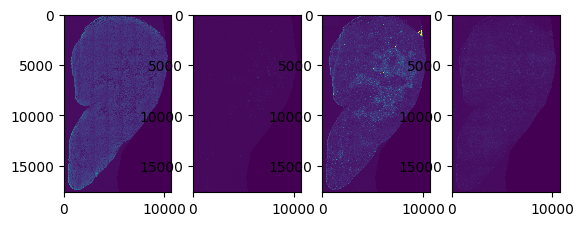

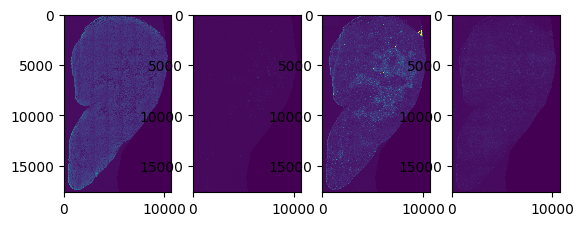

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/Sirpa_CD63_Mertk_D


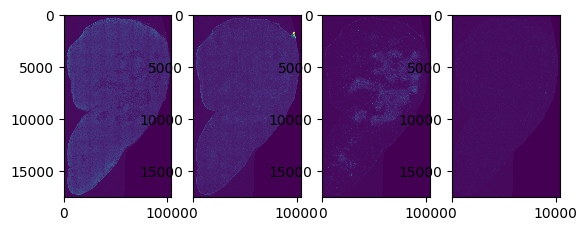

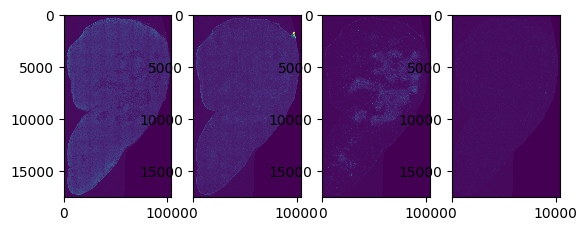

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/aDC1_D


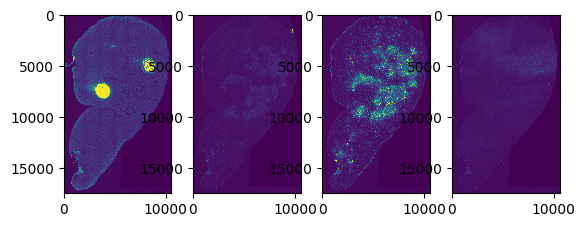

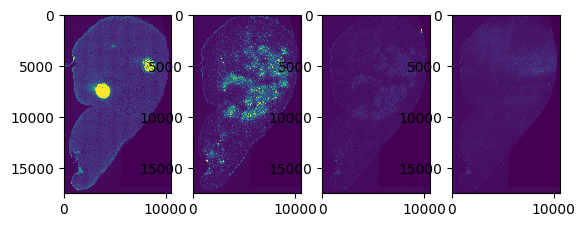

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/aDC2_D


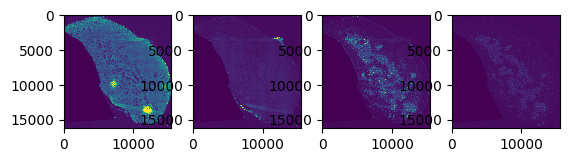

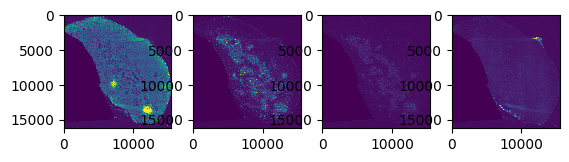

In [11]:
resolution= "20x"

for img_dir in img_dirs:
    print(img_dir)
    img_file = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if re.search(".tif$", img_file)][0]

    colin_img = tifffile.imread(img_file)
    sample_id = img_dir[-1] 
        ## The last letter is the sample ID     

    _, ax = plt.subplots(1,4)
    ax[0].imshow(colin_img[0], interpolation= "nearest")
    ax[1].imshow(colin_img[1], interpolation= "nearest")
    ax[2].imshow(colin_img[2], interpolation= "nearest")
    ax[3].imshow(colin_img[3], interpolation= "nearest")
    plt.show()

    if re.search("aDC1", img_file):
        new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_XCR1_" + sample_id
        ## Colin order: DAPI, CD11c, CD63, XCR1
        ## Needed order: DAPI, CD63, CD11c, XCR1
        colin_img = colin_img[[0,2,1,3], ...]
    elif re.search("aDC2", img_file):
        new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_Sirpa_" + sample_id
        ## Colin order: DAPI, Sirpa, CD63, CD11c
        ## Needed order: DAPI, CD63, CD11c, Sirpa
        colin_img= colin_img[[0,2,3,1], ...]
    elif re.search("CD14_cDC2", img_file):
        new_dir_name = resolution + "_pan_DAPI_Sirpa_CD11c_CD14_" + sample_id
        ## Same ordering here, only need to change directory name 
    elif re.search("CD207_cDC1", img_file):   
        new_dir_name= resolution + "_pan_DAPI_CD207_CD11c_XCR1_" + sample_id
        ## I don't have any CD207, so this ordering is fine. Although, the name is too verbose. 
    elif re.search("pDC", img_file):
        new_dir_name = resolution + "_pan_DAPI_B220_CD11c_SiglecH_" + sample_id
        ## Colin order: DAPI, B220, SiglecH, CD11c
        ## Needed order: DAPI, B220, CD11c, SiglecH
        colin_img = colin_img[[0,1,3,2], ...]
    elif re.search("Sirpa_CD63_Mertk", img_file): 
        new_dir_name = resolution + "_pan_DAPI_Sirpa_CD63_MerTK_" + sample_id
        ## I don't have any Sirpa_CD63_MerTK, so this ordering is fine. Although, the name is too verbose. 

    ## Plotting images in the loop to make sure the transpose is correct. 
    _, ax = plt.subplots(1,4)
    ax[0].imshow(colin_img[0], interpolation= "nearest")
    ax[1].imshow(colin_img[1], interpolation= "nearest")
    ax[2].imshow(colin_img[2], interpolation= "nearest")
    ax[3].imshow(colin_img[3], interpolation= "nearest")
    plt.show()

    ## New directory structure
    new_dir = os.path.join(raw_dir, new_dir_name)
    os.rename(img_dir, new_dir)
    tifffile.imwrite(os.path.join(new_dir, "image.tif"), colin_img)


    ## Making markers.csv file 
    markers_df = make_markers_file(dir_name     = new_dir_name, 
                                   resolution   = resolution,
                                   sample_id    = sample_id)
    markers_df.to_csv(os.path.join(new_dir, "markers.csv"), index= False, header= True)

## Re-running broken Sirpa_CD63_Mertk_B

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/Sirpa_CD63_Mertk_B


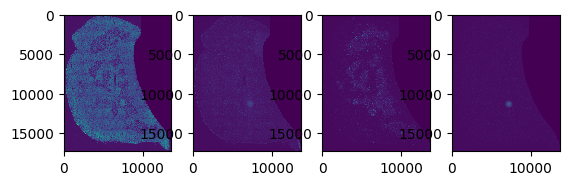

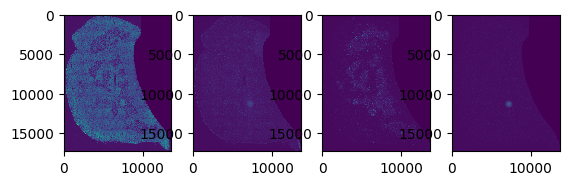

In [12]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images"
img_dir = os.path.join(raw_dir, "Sirpa_CD63_Mertk_B")
resolution= "20x"

print(img_dir)
img_file = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if re.search(".tif$", img_file)][0]

colin_img = tifffile.imread(img_file)
sample_id = img_dir[-1] 
    ## The last letter is the sample ID     

_, ax = plt.subplots(1,4)
ax[0].imshow(colin_img[0], interpolation= "nearest")
ax[1].imshow(colin_img[1], interpolation= "nearest")
ax[2].imshow(colin_img[2], interpolation= "nearest")
ax[3].imshow(colin_img[3], interpolation= "nearest")
plt.show()

if re.search("aDC1", img_file):
    new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_XCR1_" + sample_id
    ## Colin order: DAPI, CD11c, CD63, XCR1
    ## Needed order: DAPI, CD63, CD11c, XCR1
    colin_img = colin_img[[0,2,1,3], ...]
elif re.search("aDC2", img_file):
    new_dir_name = resolution + "_pan_DAPI_CD63_CD11c_Sirpa_" + sample_id
    ## Colin order: DAPI, Sirpa, CD63, CD11c
    ## Needed order: DAPI, CD63, CD11c, Sirpa
    colin_img= colin_img[[0,2,3,1], ...]
elif re.search("CD14_cDC2", img_file):
    new_dir_name = resolution + "_pan_DAPI_Sirpa_CD11c_CD14_" + sample_id
    ## Same ordering here, only need to change directory name 
elif re.search("CD207_cDC1", img_file):   
    new_dir_name= resolution + "_pan_DAPI_CD207_CD11c_XCR1_" + sample_id
    ## I don't have any CD207, so this ordering is fine. Although, the name is too verbose. 
elif re.search("pDC", img_file):
    new_dir_name = resolution + "_pan_DAPI_B220_CD11c_SiglecH_" + sample_id
    ## Colin order: DAPI, B220, SiglecH, CD11c
    ## Needed order: DAPI, B220, CD11c, SiglecH
    colin_img = colin_img[[0,1,3,2], ...]
elif re.search("Sirpa_CD63_Mertk", img_file): 
    new_dir_name = resolution + "_pan_DAPI_Sirpa_CD63_MerTK_" + sample_id
    ## I don't have any Sirpa_CD63_MerTK, so this ordering is fine. Although, the name is too verbose. 

## Plotting images in the loop to make sure the transpose is correct. 
_, ax = plt.subplots(1,4)
ax[0].imshow(colin_img[0], interpolation= "nearest")
ax[1].imshow(colin_img[1], interpolation= "nearest")
ax[2].imshow(colin_img[2], interpolation= "nearest")
ax[3].imshow(colin_img[3], interpolation= "nearest")
plt.show()

## New directory structure
new_dir = os.path.join(raw_dir, new_dir_name)
os.rename(img_dir, new_dir)
tifffile.imwrite(os.path.join(new_dir, "image.tif"), colin_img)


## Making markers.csv file 
markers_df = make_markers_file(dir_name     = new_dir_name, 
                               resolution   = resolution,
                               sample_id    = sample_id)
markers_df.to_csv(os.path.join(new_dir, "markers.csv"), index= False, header= True)

## Changing .tif to .ome.tif    

In [11]:
raw_dir= "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images"
img_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_[A-D]$", img_dir)]
img_dirs.sort()

for img_dir in img_dirs:
    convert_ome(img_dir = img_dir)
    print(f"Done with {img_dir}")

## Older Code 

In [6]:
dirs_200x = np.sort([os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_(A|B|C)$", img_dir) and re.search("200x", img_dir)])

for img_dir in dirs_200x:
    print(img_dir)


/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_B220_CD11c_SiglecH_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_B220_CD11c_SiglecH_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_B220_CD11c_SiglecH_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD207_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD207_CD11c_XCR1_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD207_CD11c_XCR1_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD63_CD11c_Sirpa_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD63_CD11c_Sirpa_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD63_CD11c_Sirpa_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD63_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD

In [108]:
dirs_200x = np.sort([os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_(A|B|C)$", img_dir) and re.search("200x", img_dir)])
resolution = "20x"

for img_dir in dirs_200x:
    print(img_dir)
    sample_id = img_dir[-1] 
    print(sample_id)

    img_name = re.sub(raw_dir + "/", "", img_dir)
    print(img_name)

    markers_df = make_markers_file(dir_name     = img_name, 
                                   resolution   = resolution,
                                   sample_id    = sample_id)
    markers_df.to_csv(os.path.join(img_dir, "markers.csv"), index= False, header= True)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_B220_CD11c_SiglecH_A
A
200x_pan_DAPI_B220_CD11c_SiglecH_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_B220_CD11c_SiglecH_B
B
200x_pan_DAPI_B220_CD11c_SiglecH_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_B220_CD11c_SiglecH_C
C
200x_pan_DAPI_B220_CD11c_SiglecH_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD207_CD11c_XCR1_A
A
200x_pan_DAPI_CD207_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD207_CD11c_XCR1_B
B
200x_pan_DAPI_CD207_CD11c_XCR1_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD207_CD11c_XCR1_C
C
200x_pan_DAPI_CD207_CD11c_XCR1_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD63_CD11c_Sirpa_A
A
200x_pan_DAPI_CD63_CD11c_Sirpa_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/200x_pan_DAPI_CD63_CD11c_Sirpa_B
B
200x_

In [12]:
## Renaming 200x directories to 20x directories
    ## Colin had a typo in his original names

dirs_200x = np.sort([os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_(A|B|C)$|_(A|B|C)_", img_dir) and re.search("200x", img_dir)])


for img_dir in dirs_200x:
    new_dir = re.sub("/200x_", "/20x_", img_dir) ## more specific regex to match only the start of the final dir
    print(new_dir)
    os.rename(img_dir, new_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_A_cortex_and_background
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_CD207_CD11c_XCR1_A_medulla
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD63_MerTK_C_cortex_and_background
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/20x_pan_DAPI_Sirpa_CD63_MerTK_C_medulla
